In [84]:
!pip install ultralytics

In [85]:
!pip install pyttsx3
!apt install espeak

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak is already the newest version (1.48.15+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import ultralytics
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from skimage.metrics import structural_similarity
from ultralytics import YOLO
import threading
import pyttsx3
import time
import math

# Adaptive Thresholding

In [26]:
cap = cv2.VideoCapture('vehicle_fire.mp4')

arr = np.empty((0, 256), int)

start_time = time.time()
while cap.isOpened():

    ret, frame = cap.read()

    if ret == True:
        frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist(frame, [0], None, [256], [0, 256])
        hist1= hist.flatten()
        #print(hist1.shape)
        arr =np.vstack((arr, list(hist1)))
    else:
        break

print("--- %s seconds ---" % (time.time() - start_time))

print(arr.shape)

--- 2.4086570739746094 seconds ---
(1168, 256)


In [27]:
#similarity threshold
stat = [arr.mean(), arr.std()]
print(stat)
stat = np.array(stat)
normalized_stat = stat / np.linalg.norm(stat)
adaptive_threshold = normalized_stat[1]*1 + normalized_stat[0]*0.1
adaptive_threshold

[15.0, 32.40891209128941]


0.9495137919424317

In [28]:
#dense cluster threshold
cluster_threshold = math.floor(stat[0]) + math.floor(stat[1])
cluster_threshold

47

# Key Frame Extraction

In [29]:
cap = cv2.VideoCapture('vehicle_fire.mp4')

arr = np.empty((0, 1944), int)   #1944 dimensional array for feature vector
D=dict()
count=0
start_time = time.time()
while cap.isOpened():

    # Read the video file.
    ret, frame = cap.read()

    if ret == True:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        D[count] = frame_rgb

        #3*3 = 9 blocks
        height, width, channels = frame_rgb.shape

        if height % 3 == 0:
            h_chunk = int(height/3)
        else:
            h_chunk = int(height/3) + 1

        if width % 3 == 0:
            w_chunk = int(width/3)
        else:
            w_chunk = int(width/3) + 1

        h=0
        w= 0
        feature_vector = []
        for a in range(1,4):
            h_window = h_chunk*a
            for b in range(1,4):
                frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])
                hist1= hist.flatten()
                feature_vector += list(hist1)
                w = w_chunk*b

            h = h_chunk*a
            w= 0


        arr =np.vstack((arr, feature_vector )) #N*M matrix (N is number of frames and M is 1944)
        count+=1
    else:
        break

print("--- %s seconds ---" % (time.time() - start_time))

final_arr = arr.transpose() # M*N

print(final_arr.shape)
print(count)

--- 4.9857940673828125 seconds ---
(1944, 1168)
1168


In [30]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
A = csc_matrix(final_arr, dtype=float) #sparse matrix

In [31]:
#type(final_arr)

In [32]:
col = []
for i in range(0,count):
    col.append(i)

col[0:1]

[0]

In [33]:
import pandas as pd

df1 = pd.DataFrame(final_arr, columns=col)
df1

,0,1,2,3,4,5,6,7,8,9,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,408.0,408.0,408.0,408.0,409.0,414.0,415.0,415.0,414.0,414.0,...,353.0,439.0,418.0,418.0,416.0,388.0,345.0,339.0,341.0,364.0
1,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,...,1.0,0.0,0.0,0.0,0.0,3.0,10.0,10.0,8.0,8.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
steps = [('scaler', StandardScaler()), ('pca', PCA())]
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps) # define the pipeline object.

In [35]:
parameters = {
    "pca__n_components": [10, 20, 30, 40, 50, 60],
}

In [36]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [37]:
grid.fit(df1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA())]),
             param_grid={'pca__n_components': [10, 20, 30, 40, 50, 60]})

In [38]:
print("score = %3.2f" %(grid.score(df1)))
print(grid.best_params_)

score = 21.63
{'pca__n_components': 10}


In [39]:
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df1))
scaled_data

,0,1,2,3,4,5,6,7,8,9,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,6.281411,6.281411,6.279662,6.275165,6.288146,6.365027,6.378507,6.378507,6.364820,6.362444,...,6.598854,8.305092,7.989692,7.724579,7.741145,7.286167,6.500949,6.558953,6.382777,6.994078
1,0.126137,0.126137,0.126102,0.126012,0.125959,0.125937,0.125895,0.125895,0.125933,0.125886,...,-0.093656,-0.113642,-0.114898,-0.111085,-0.111866,-0.055798,0.078111,0.080227,0.039509,0.040512
2,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
3,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
4,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
1940,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
1941,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748
1942,-0.092578,-0.092578,-0.092552,-0.092486,-0.092447,-0.092431,-0.092400,-0.092400,-0.092428,-0.092393,...,-0.112669,-0.113642,-0.114898,-0.111085,-0.111866,-0.113008,-0.113616,-0.116694,-0.112882,-0.115748


In [40]:
pca_c =  grid.best_params_['pca__n_components']
pca_c

10

In [41]:
colnames = []
for i in range(1, pca_c+1):
    col_name = "v" + str(i)
    colnames+= [col_name]
print(colnames)

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10']


In [42]:
scaled_data1 = scaled_data.transpose()

In [43]:
pca = PCA(n_components = pca_c)
pca.fit(scaled_data1)
data_pca = pca.transform(scaled_data1)
data_pca = pd.DataFrame(data_pca,columns=colnames)
data_pca.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10
0,25.602248,-7.785561,-5.523801,5.439360,2.408144,-0.272323,0.084390,0.198408,3.887583,0.592050
1,25.602248,-7.785561,-5.523801,5.439360,2.408144,-0.272323,0.084390,0.198408,3.887583,0.592050
2,25.578327,-7.832643,-5.534472,5.453971,2.361262,-0.274214,0.037920,0.211476,3.860271,0.607147
3,25.572494,-7.844977,-5.535256,5.454204,2.302313,-0.238562,0.044122,0.182063,3.833713,0.640852
4,25.593345,-7.856949,-5.518815,5.413078,2.254080,-0.239502,0.031408,0.156788,3.864849,0.604962


In [44]:
#data_pca.shape

In [45]:
df2 = data_pca.transpose()

In [46]:
#df2.shape

In [47]:
projections = data_pca.to_numpy()

In [49]:
f=projections
C = dict() #clusters
for i in range(f.shape[0]):
    C[i] = np.empty((0,pca_c), int)

#first two projected frames in first cluster
C[0] = np.vstack((C[0], f[0]))
C[0] = np.vstack((C[0], f[1]))

E = dict() #centroids
for i in range(projections.shape[0]):
    E[i] = np.empty((0,pca_c), int)

E[0] = np.mean(C[0], axis=0) #finding centroid of C[0] cluster

count = 0
for i in range(2,f.shape[0]):
    #print(i)
    similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) #cosine similarity
    #similarity = structural_similarity(f[i], E[count])
    print(similarity)


    if similarity < adaptive_threshold:

        count+=1
        C[count] = np.vstack((C[count], f[i]))
        E[count] = np.mean(C[count], axis=0)
    else:
        C[count] = np.vstack((C[count], f[i]))
        E[count] = np.mean(C[count], axis=0)

0.9999946704029593
0.9999896282460629
0.9999874739595016
0.9999857850048595
0.9999554912310278
0.9999673083383613
0.9999397447674423
0.9999317045772029
0.9999597466917675
0.9999131998835581
0.999931761983804
0.9999348139603038
0.9999708612057268
0.9999340139340158
0.9996322198249651
0.9993244292321856
0.9989042372057491
0.9989574696000917
0.9988528552063342
0.9986699751818302
0.9964874241071313
0.994879625865347
0.9989866446225657
0.9991056800955239
0.9965234613464472
0.992542212414853
0.9916880031072827
0.9900252811169821
0.9911595602126965
0.9914111474119229
0.99046334439586
0.9891029513293286
0.9897084655089206
0.9880603881881314
0.9901008846043227
0.9905411726347584
0.9911474230755662
0.9881414922601666
0.9840881659800862
0.983752659657026
0.9838886453148877
0.9845445801275964
0.9854438132263571
0.9829582284886239
0.9748441594665526
0.9750122184383188
0.9721955096143201
0.973168068101066
0.9773006127807703
0.9796596977168152
0.9744121710475507
0.9710096967809051
0.9690126929395478


In [50]:
b = []  #number of data points in each cluster

for i in range(f.shape[0]):
    b.append(C[i].shape[0])

In [51]:
#C[0].shape

In [52]:
#b

In [53]:
last = b.index(0)
b1=b[:last ]
len(b1)

141

In [54]:
count = 1
while True:
    res = [idx for idx, val in enumerate(b1) if val >= (cluster_threshold/count)]
    #print("Res",len(res))
    #print("Count",count)
    if len(res)>=10:
        print("CLUSTER ThRESHOLD=",math.floor(cluster_threshold/count))
        break
    count+=1

print(len(res))
res

CLUSTER ThRESHOLD= 23
14


[0, 3, 4, 10, 12, 13, 15, 17, 24, 28, 31, 35, 113, 117]

In [55]:
GG = C #label each cluster
for i in range(last):
    p1= np.repeat(i, b1[i]).reshape(b1[i],1)
    GG[i] = np.hstack((GG[i],p1))

In [56]:
F=  np.empty((0,pca_c+1), int)
for i in range(last):
    F = np.vstack((F,GG[i]))

In [57]:
F.shape

(1168, 11)

In [58]:
colnames = []
for i in range(1, pca_c+2):
    col_name = "v" + str(i)
    colnames+= [col_name]
print(colnames)

df = pd.DataFrame(F, columns= colnames)

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11']


In [59]:
last_col = df.columns[-1]

In [60]:
df[last_col]= df[last_col].astype(int)

In [61]:
df1 =  df[df[last_col].isin(res)]

In [62]:
new = df1.groupby(last_col).tail(1)[last_col] #last element of each cluster

In [63]:
new1 = new.index
new1

Index([67, 124, 166, 263, 294, 323, 380, 420, 474, 557, 615, 661, 992, 1055], dtype='int64')

In [64]:
len(new1)

14

In [65]:
keyframe_dict = dict()
for i in new1:
    keyframe_dict[i] = D[i]

In [66]:
keyframe_arr = list(keyframe_dict.values())

In [67]:
keyframe_arr[0].shape

(720, 1280, 3)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


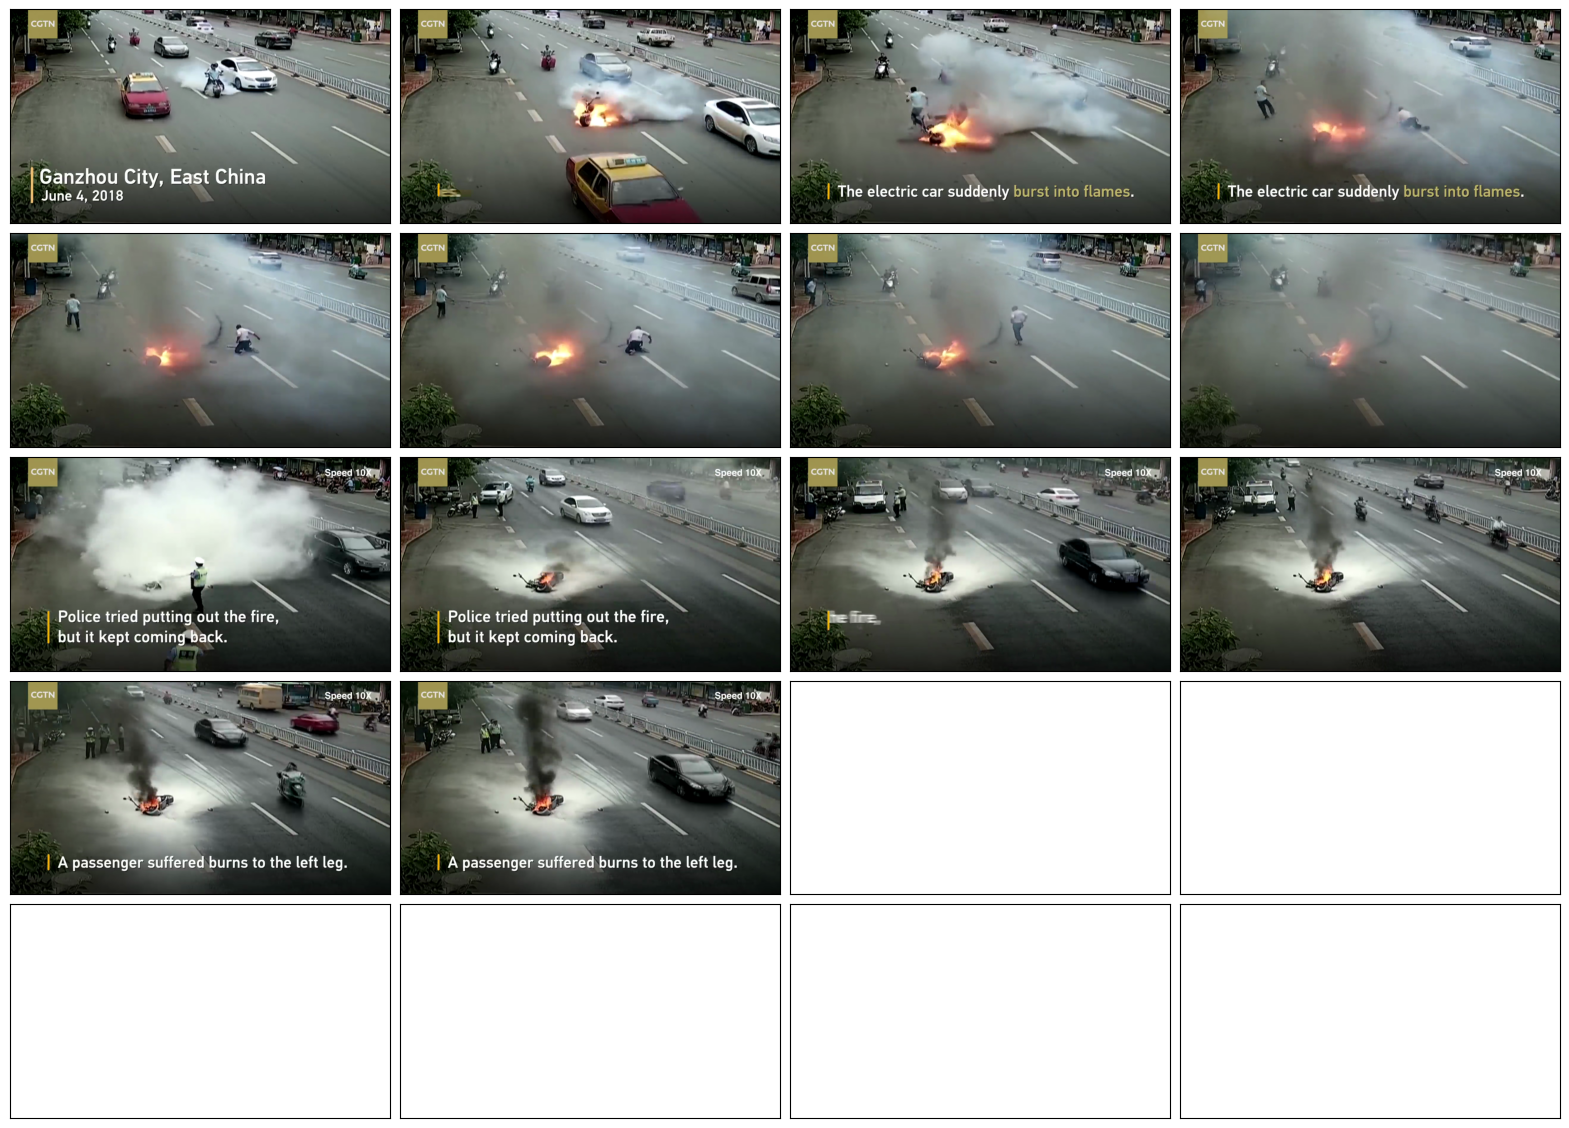

In [68]:
# similarity ?
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5,4),
                 axes_pad=0.1,
                 share_all=True
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

for ax, im in zip(grid, keyframe_arr):
    print(im.shape)
    ax.imshow(im)

In [71]:
frameSize = (keyframe_arr[0].shape[1], keyframe_arr[0].shape[0])
output = cv2.VideoWriter('output_vehicle_fire.mp4v', cv2.VideoWriter_fourcc(*'DIVX'), 40, frameSize)
for frame in keyframe_arr:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output.write(frame_rgb)
output.release()

# YOLO Detection

In [4]:
def thread_voice_alert_handgun(engine):
    engine.say("Handgun Detected")
    engine.runAndWait()

def thread_voice_alert_shotgun(engine):
    engine.say("Shotgun Detected")
    engine.runAndWait()

def thread_voice_alert_knife(engine):
    engine.say("Knife Detected")
    engine.runAndWait()

def thread_voice_alert_fire(engine):
    engine.say("Fire Detected")
    engine.runAndWait()

In [5]:
engine = pyttsx3.init("dummy")
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)
engine.setProperty('rate', 150)

In [79]:
#!pip install py3-tts

  Obtaining dependency information for py3-tts from https://files.pythonhosted.org/packages/fb/34/2691608c5f88afe2af4245d371d77f2879fd4cc32e9cdf00102ba3da5a8e/py3_tts-3.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.5/388.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 6.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 8.1 MB/s eta 0:00:00


  Attempting uninstall: pyobjc-core
    Found existing installation: pyobjc-core 10.1
    Uninstalling pyobjc-core-10.1:
      Successfully uninstalled pyobjc-core-10.1
  Attempting uninstall: pyobjc-framework-libdispatch
    Found existing installation: pyobjc-framework-libdispatch 10.1
    Uninstalling pyobjc-framework-libdispatch-10.1:
      Successfully uninstalled pyobjc-framework-libdispatch-10.1
  Attempting uninstall: pyobjc-framework-Cocoa
    Found existing installation: pyobjc-framework-Cocoa 10.1
    Uninstalling pyobjc-framework-Cocoa-10.1:
      Successfully uninstalled pyobjc-framework-Cocoa-10.1
  Attempting uninstall: pyobjc-framework-WebKit
    Found existing installation: pyobjc-framework-WebKit 10.1
    Uninstalling pyobjc-framework-WebKit-10.1:
      Successfully uninstalled pyobjc-framework-WebKit-10.1
  Attempting uninstall: pyobjc-framework-Virtualization
    Found existing installation: pyobjc-framework-Virtualization 10.1
    Uninstalling pyobjc-framework-Virt

    Found existing installation: pyobjc-framework-StoreKit 10.1
    Uninstalling pyobjc-framework-StoreKit-10.1:
      Successfully uninstalled pyobjc-framework-StoreKit-10.1
  Attempting uninstall: pyobjc-framework-Speech
    Found existing installation: pyobjc-framework-Speech 10.1
    Uninstalling pyobjc-framework-Speech-10.1:
      Successfully uninstalled pyobjc-framework-Speech-10.1
  Attempting uninstall: pyobjc-framework-SoundAnalysis
    Found existing installation: pyobjc-framework-SoundAnalysis 10.1
    Uninstalling pyobjc-framework-SoundAnalysis-10.1:
      Successfully uninstalled pyobjc-framework-SoundAnalysis-10.1
  Attempting uninstall: pyobjc-framework-Social
    Found existing installation: pyobjc-framework-Social 10.1
    Uninstalling pyobjc-framework-Social-10.1:
      Successfully uninstalled pyobjc-framework-Social-10.1
  Attempting uninstall: pyobjc-framework-ShazamKit
    Found existing installation: pyobjc-framework-ShazamKit 10.1
    Uninstalling pyobjc-framew

    Found existing installation: pyobjc-framework-KernelManagement 10.1
    Uninstalling pyobjc-framework-KernelManagement-10.1:
      Successfully uninstalled pyobjc-framework-KernelManagement-10.1
  Attempting uninstall: pyobjc-framework-iTunesLibrary
    Found existing installation: pyobjc-framework-iTunesLibrary 10.1
    Uninstalling pyobjc-framework-iTunesLibrary-10.1:
      Successfully uninstalled pyobjc-framework-iTunesLibrary-10.1
  Attempting uninstall: pyobjc-framework-IOSurface
    Found existing installation: pyobjc-framework-IOSurface 10.1
    Uninstalling pyobjc-framework-IOSurface-10.1:
      Successfully uninstalled pyobjc-framework-IOSurface-10.1
  Attempting uninstall: pyobjc-framework-Intents
    Found existing installation: pyobjc-framework-Intents 10.1
    Uninstalling pyobjc-framework-Intents-10.1:
      Successfully uninstalled pyobjc-framework-Intents-10.1
  Attempting uninstall: pyobjc-framework-InstallerPlugins
    Found existing installation: pyobjc-framewor

    Found existing installation: pyobjc-framework-CoreAudio 10.1
    Uninstalling pyobjc-framework-CoreAudio-10.1:
      Successfully uninstalled pyobjc-framework-CoreAudio-10.1
  Attempting uninstall: pyobjc-framework-Contacts
    Found existing installation: pyobjc-framework-Contacts 10.1
    Uninstalling pyobjc-framework-Contacts-10.1:
      Successfully uninstalled pyobjc-framework-Contacts-10.1
  Attempting uninstall: pyobjc-framework-ColorSync
    Found existing installation: pyobjc-framework-ColorSync 10.1
    Uninstalling pyobjc-framework-ColorSync-10.1:
      Successfully uninstalled pyobjc-framework-ColorSync-10.1
  Attempting uninstall: pyobjc-framework-Collaboration
    Found existing installation: pyobjc-framework-Collaboration 10.1
    Uninstalling pyobjc-framework-Collaboration-10.1:
      Successfully uninstalled pyobjc-framework-Collaboration-10.1
  Attempting uninstall: pyobjc-framework-ClassKit
    Found existing installation: pyobjc-framework-ClassKit 10.1
    Unins

    Found existing installation: pyobjc-framework-OSLog 10.1
    Uninstalling pyobjc-framework-OSLog-10.1:
      Successfully uninstalled pyobjc-framework-OSLog-10.1
  Attempting uninstall: pyobjc-framework-ModelIO
    Found existing installation: pyobjc-framework-ModelIO 10.1
    Uninstalling pyobjc-framework-ModelIO-10.1:
      Successfully uninstalled pyobjc-framework-ModelIO-10.1
  Attempting uninstall: pyobjc-framework-MetalPerformanceShaders
    Found existing installation: pyobjc-framework-MetalPerformanceShaders 10.1
    Uninstalling pyobjc-framework-MetalPerformanceShaders-10.1:
      Successfully uninstalled pyobjc-framework-MetalPerformanceShaders-10.1
  Attempting uninstall: pyobjc-framework-MetalKit
    Found existing installation: pyobjc-framework-MetalKit 10.1
    Uninstalling pyobjc-framework-MetalKit-10.1:
      Successfully uninstalled pyobjc-framework-MetalKit-10.1
  Attempting uninstall: pyobjc-framework-MetalFX
    Found existing installation: pyobjc-framework-Meta

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd /content/drive/MyDrive/new final fyp code folder/yolov8-50b-320i/weights/

In [ ]:
#!ls

In [6]:
model = YOLO("best.pt")

In [7]:
video_path = "output_vehicle_fire.mp4"
cap = cv2.VideoCapture(video_path)
no_frames = 0
start_time = time.time()
while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = model(frame)
        #print(results[0].boxes.cls)
        no_frames+=1
        try:
            if (results[0].boxes.conf[0] > 0.60):
                c = results[0].boxes.cls[0]
                try:
                    if (c == 2):
                        t = threading.Thread(target=thread_voice_alert_handgun, args=(engine,))
                        t.start()
                    elif (c == 3):
                        t = threading.Thread(target=thread_voice_alert_shotgun, args=(engine,))
                        t.start()
                    elif(c == 1):
                        t = threading.Thread(target=thread_voice_alert_knife, args=(engine,))
                        t.start()
                    elif(c == 0):
                        t = threading.Thread(target=thread_voice_alert_fire, args=(engine,))
                        t.start()
                except:
                    pass

                annotated_frame = results[0].plot()
                cv2.imshow("YOLOv8 Inference", annotated_frame)

            else:
                cv2.imshow("YOLOv8 Inference", frame)
        except:
            pass

        if cv2.waitKey(1001) & 0xFF == ord("q"):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()
end_time = time.time()
optimised_time=end_time - start_time - no_frames
print("#####PROCESSING TIME##### =", optimised_time, "seconds")


0: 192x320 1 knife, 65.9ms
Speed: 1.8ms preprocess, 65.9ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 1 fire, 64.1ms
Speed: 1.2ms preprocess, 64.1ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 1 fire, 69.8ms
Speed: 1.7ms preprocess, 69.8ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 1 fire, 68.2ms
Speed: 1.8ms preprocess, 68.2ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 1 fire, 60.1ms
Speed: 1.1ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 2 fires, 62.0ms
Speed: 1.1ms preprocess, 62.0ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 2 fires, 59.8ms
Speed: 1.1ms preprocess, 59.8ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 1 fire, 62.0ms
Speed: 1.1ms preprocess, 62.0ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)

0: 1

# Testing

In [ ]:
video_path = "vehicle_fire.mp4"
cap = cv2.VideoCapture(video_path)
start_time = time.time()
while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = model(frame)
        #print(results[0].boxes.cls)
        try:
            if (results[0].boxes.conf[0] > 0.50):
                c = results[0].boxes.cls[0]
                try:
                    if (c == 2):
                        t = threading.Thread(target=thread_voice_alert_handgun, args=(engine,))
                        t.start()
                    elif (c == 3):
                        t = threading.Thread(target=thread_voice_alert_shotgun, args=(engine,))
                        t.start()
                    elif(c == 1):
                        t = threading.Thread(target=thread_voice_alert_knife, args=(engine,))
                        t.start()
                    elif(c == 0):
                        t = threading.Thread(target=thread_voice_alert_fire, args=(engine,))
                        t.start()
                except:
                    pass

                annotated_frame = results[0].plot()
                cv2.imshow("YOLOv8 Inference", annotated_frame)

            else:
                cv2.imshow("YOLOv8 Inference", frame)
        except:
            pass

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()
end_time = time.time()
original_time = end_time - start_time
print("#####PROCESSING TIME##### =", original_time, "seconds")

In [86]:
times = [original_time, optimised_time]
times_series = pd.Series(times)
per_change = times_series.pct_change()
per_change

0         NaN
1   -0.981061
dtype: float64